# Lab 4

In the computer labs we will work with the Python programming language within a Jupyter notebook. Each week a new notebook is made available that contains the exercises that are to be handed-in. 

* It is expected that you work individually and the usual plagarism rules apply.
* Submissions are to be made on canvas. Make sure that you add your student ID in the submission comments.
* The main notebook file you submit should read "Lab[number]_[last name].ipynb", for example "Lab2_Bongers.ipynb". 
* Please make sure your code will run without problems

_You need to fill in everywhere that there is a_ '__TODO__'

Feel free ask any questions during the computer lab sessions, or email the TA.

**The due date for this lab is Monday 29th October 2018 at 14:59**

In [1]:
# Load the numpy numerical computation library
import numpy as np

# Load matplotlib, which controls plotting pretty graphs
import matplotlib.pyplot as plt
%matplotlib inline

try:
    from urllib.request import urlopen
except ImportError:
    # Python 2
    from urllib2 import urlopen

## Exercise 1 - Plain linear regression

You are being given data from scikit learn http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html.

The data consists of the monthly average atmospheric CO2 concentrations (in parts per million by volume (ppmv)) collected at the Mauna Loa Observatory in Hawaii, between 1958 and 2001. The objective is to model the CO2 concentration as a function of the time $t$.

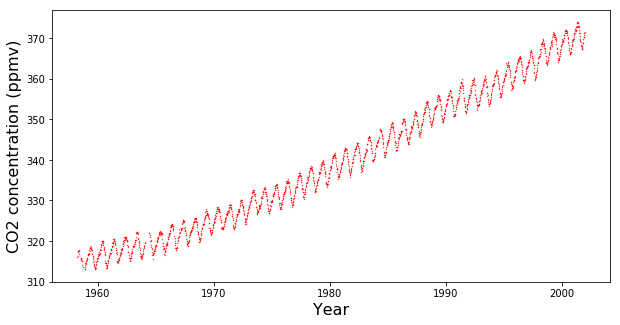

In [2]:
def load_mauna_loa_atmospheric_c02():
    url = ('http://cdiac.ess-dive.lbl.gov/'
           'ftp/trends/co2/sio-keel-flask/maunaloa_c.dat')
    dates = []
    ppmvs = []
    with urlopen(url) as f:
        for line in f:
            line = line.decode('utf8')
            if not line.startswith('MLO'):
                # ignore headers
                continue
            station, date, weight, flag, ppmv = line.split()
            y = date[:2]
            m = date[2:4]
            d = date[4:]
            date = np.datetime64('%s%s-%s-%s' %
                                 ('20' if y < '20' else '19', y, m, d))
            dates.append(date)
            ppmvs.append(float(ppmv))
    dates = np.asarray(dates)
    # dates expressed as decimal years
    dates = dates.astype('float') / 365.2425 + 1970
    ppmvs = np.asarray(ppmvs)
    return dates.reshape(-1, 1), ppmvs

Xtrain, ytrain = load_mauna_loa_atmospheric_c02()

plt.figure(figsize=(10,5))
plt.plot(Xtrain,ytrain,'r.',markersize=0.7)
plt.xlabel('Year', fontsize=16)
plt.ylabel('CO2 concentration (ppmv)', fontsize=16)
plt.show()

Xtrain = np.stack([Xtrain[:,0], np.ones((Xtrain.shape[0],))])

*Note bene*: In all of the following, we use `N` to denote the number of training points, `D+1` to denote the dimensionality of the parameter space (`D` is the dimension without a bias), `Xtrain` to denote the training inputs and `ytrain` to denote the training labels.

__TODO 1__ Complete the function `log_likelihood(y,X,w,sigma2)` which given `y, X, w, sigma2` computes the log-likelihood $\mathcal{L}(\textbf{w},\sigma^2)$ of a Gaussian (as defined in the slides), where $\textbf{w}=[w,b]^\top$ and $\sigma^2 = \texttt{sigma2}$ and the data set is $\mathcal{D}=(\textbf{X},\textbf{y})$. The expression is
\begin{align}
    \mathcal{L}(\textbf{w}, \sigma^2) = -\frac{N}{2} \log 2 \pi \sigma^2 - \frac{1}{2\sigma^2}(\textbf{y} - \textbf{X}^\top\textbf{w})^\top(\textbf{y} - \textbf{X}^\top\textbf{w})
\end{align}

In [3]:
def log_likelihood(y,X,w,sigma2):
    """Return the log-likelihood
    y: A [N] vector of labels
    X: A [N,D+1] matrix of inputs
    w: A [D+1] vector of parameters
    sigma2: A positive scalar for the variance
    
    Returns:
        This must return a scalar log-likelihood
    """
    vector = ((np.array([y])).T-(np.matmul(X.T,(np.array([w]).T))))
    return np.asscalar(-(len(y)/2)*np.log(2*np.pi*sigma2) - (1/(2*sigma2))*np.matmul(vector.T,vector))

#given to students
sigma2 = 2
w = np.array([1,2])
print("Log-lik. = {}".format(log_likelihood(ytrain,Xtrain,w,sigma2)))
# Correct answer should be roughly: -1500463954

Log-lik. = -1500463954.196213


We now plot the likelihood function. You should note that it is not very informative about the location of the minimum.

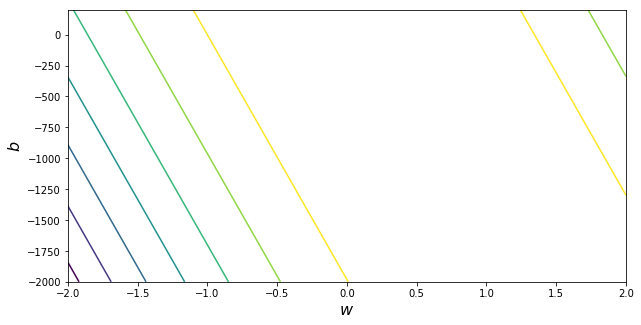

In [4]:
sigma2 = 2.

# Create a grid of parameter values
resolution = 200
w = np.linspace(-2, 2, resolution)
b = np.linspace(-2000, 200, resolution)
Wgrid, Bgrid = np.meshgrid(w, b)
W = np.stack([Wgrid,Bgrid]).reshape([2,-1])

# Slow but sure way to probe llik values
Z1 = []
for i in range(W.shape[1]):
    Z1.append(log_likelihood(ytrain,Xtrain,W[:,i],sigma2))
Z1 = np.array(Z1).reshape([resolution,resolution])

# Plotting
plt.figure(figsize=(10,5))
plt.contour(Wgrid ,Bgrid, Z1)
plt.xlabel('$w$', fontsize=16)
plt.ylabel('$b$', fontsize=16)
plt.show()

We will now estimate and also compute the values of $\textbf{w}_{ML}$ and $\sigma_{ML}$ that maximize the log-likelihood. We will do this in 2 different ways:

(1) using the `argmax` function (from numpy) to find the maximum in the array `Z1`. This is given to you.

(2) using the formulas from the slides for $\textbf{w}_\text{ML}$ and $\sigma_\text{ML}^2$. You need to complete this.

We have written method (1), the brute force method, for you

In [5]:
index1 = np.argmax(Z1)

wBRUTE = W[:,index1]
print("wBRUTE={}, bBRUTE={}".format(wBRUTE[0], wBRUTE[1]))

wBRUTE=1.1758793969849246, bBRUTE=-1988.9447236180904


Recall that the training inputs `Xtrain` is the following matrix, 
$$
\textbf{X} = \begin{bmatrix}
x_1 & \dots & x_N \\
1 & \dots & 1 
\end{bmatrix}
$$

__TODO 2__ Write a function `w_ml(X,y)` that compute the values of $\textbf{w}_{ML}$ (where `X`is a $2 \times N$ matrix and `y` is a vector of size $N$). Recall that $\textbf{w}_{ML}$ is equal to (see slides) 
$$
\textbf{w}_{ML} = (\textbf{X} \textbf{X}^T)^{-1} \textbf{X} \; \textbf{y}
$$

In [6]:
def w_ml(X,y):
    """Return the ML parameters
    X: A [N,D+1] matrix of inputs
    y: A [N] vector of labels
    
    Returns:
        This must return a [D+1] vector of parameters
    """
    return np.matmul((np.matmul(np.linalg.inv(np.matmul(X, X.T)), X)), y)

wML=1.3429174158307116, bML=-2319.5438311063003


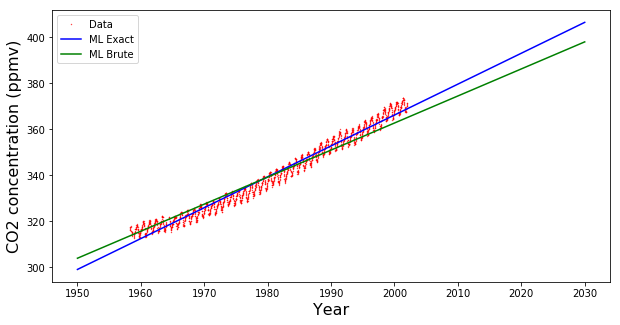

In [7]:
wML = w_ml(Xtrain,ytrain)
print("wML={}, bML={}".format(wML[0], wML[1]))

xtest = np.stack([np.linspace(1950, 2030, 100), np.ones(100)])
yML = xtest.T @ wML
yBRUTE = xtest.T @ wBRUTE

plt.figure(figsize=(10,5))
plt.plot(Xtrain[0,:],ytrain,'r.',markersize=0.7)
plt.plot(xtest[0,:],yML, 'b')
plt.plot(xtest[0,:],yBRUTE, 'g')
plt.legend(['Data', 'ML Exact', 'ML Brute'])

plt.xlabel('Year', fontsize=16)
plt.ylabel('CO2 concentration (ppmv)', fontsize=16)
plt.show()

__TODO 3__ Complete the function below to return the maximum likelihood standard deviation $\sigma_\text{ML}$. The expression is
\begin{align}
    \sigma_{\text{ML}}^2 = \frac{1}{N}(\textbf{y} - \textbf{X}^\top\textbf{w})^\top(\textbf{y} - \textbf{X}^\top\textbf{w})
\end{align}

In [8]:
def sigma_ml(y,X,w):
    """Return the ML parameters
    X: A [N,D+1] matrix of inputs
    y: A [N] vector of labels
    w: A [D+1] vector of parameters
    
    Returns:
        This must return a scalar standard deviation (not the variance!)
    """
    vector = ((np.array([y])).T-(np.matmul(X.T,(np.array([w]).T))))
    return np.asscalar(np.sqrt((1/len(y))*(np.matmul(vector.T,vector))))

We now plot the ML line and $\pm2\sigma$ lines

sigmaML=2.758561532895827


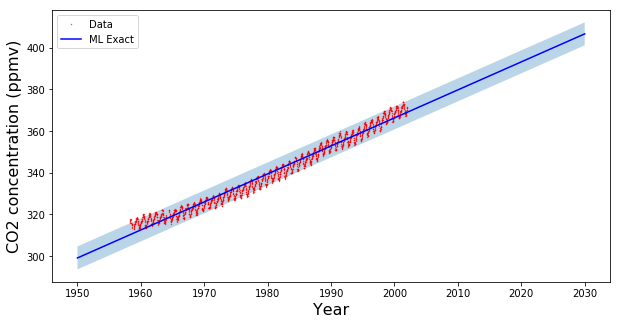

In [9]:
# Compute sigmaML
sigmaML = sigma_ml(ytrain,Xtrain,wML)
print("sigmaML={}".format(sigmaML))

# Compute the test predictions under the ML regime
xtest = np.stack([np.linspace(1950, 2030, 100), np.ones(100)])
ytest = xtest.T @ wML
yupper = ytest + 2*sigmaML
ylower = ytest - 2*sigmaML

# Plotting
plt.figure(figsize=(10,5))
plt.plot(Xtrain[0,:],ytrain,'r.',markersize=0.7)
plt.plot(xtest[0,:],ytest, 'b')
plt.fill_between(xtest[0,:], ylower, yupper, alpha=0.3)
plt.legend(['Data', 'ML Exact'])

plt.xlabel('Year', fontsize=16)
plt.ylabel('CO2 concentration (ppmv)', fontsize=16)
plt.show()

## Exercise 2 - Linear regression with features

Instead of using plain linear regression, we will use a more sophisticated linear regression using a feature transformation and see if the approximation that we obtain is better than in the linear case. See the slides for the theory about a feature transformation.

__TODO 4__ First, fill in the function `feature_transform(x)` that takes a vector of input data $\textbf{x} = [x_1,x_2,...,x_N]$ as an input. The function should output the matrix 
$$
\mathbf{\Phi} = \texttt{feature_transform}(\textbf{x}) = \begin{bmatrix}
x_1 & \dots & x_N \\
x_1^2 & \dots & x_N^2 \\
\cos(2 \pi x_1) & \dots & \cos(2 \pi x_N) \\
\sin(2 \pi x_1) & \dots & \sin(2 \pi x_N) \\
\cos(4\pi x_1) & \dots & \cos(4\pi x_N) \\
\sin(4\pi x_1) & \dots & \sin(4\pi x_N) \\
\cos(6\pi x_1) & \dots & \cos(6\pi x_N) \\
\sin(6\pi x_1) & \dots & \sin(6\pi x_N) \\
1 & \dots & 1 
\end{bmatrix}
$$

In [10]:
def feature_transform(x):
    """Returns a feature matrix Phi
    x: a [N] vector of inputs
    
    Returns:
        a [9,N] matrix of outputs
    """
    A = [x,]
    A.append(x**2)
    for i in range(1,4):
        A.append(np.cos(i*2*np.pi*x))
        A.append(np.sin(i*2*np.pi*x))
    A.append(np.ones(x.shape))
    A = np.vstack(A)
    return A

We now use $\mathbf{\Phi}$ to compute the ML parameters $\textbf{w}_\text{ML}$, where
$$
\textbf{w}^{feat}_{ML} = (\mathbf{\Phi} \mathbf{\Phi}^T)^{-1} \mathbf{\Phi} \mathbf{y}
$$
We do this, reusing the code `w_ml` which you wrote earlier.

In [11]:
Phitrain = feature_transform(Xtrain[0,:])

# ML estimates in feature space
wML = w_ml(Phitrain,ytrain)
sigmaML = sigma_ml(ytrain,Phitrain,wML)
print("sigma=ML{}, wML={}".format(sigmaML, wML))

sigma=ML0.7939792939104783, wML=[-4.49449582e+01  1.16870517e-02 -1.00017361e+00  2.62816449e+00
  6.30218395e-01 -4.29814311e-01  3.32592850e-02 -1.20397573e-01
  4.35107261e+04]


This piece of code will plot the result for you. Notice that the error bars are very tight around the mean even very far away from the data, this is because we use performing maximum likelihood, which tends to make erroneously confident predictions.

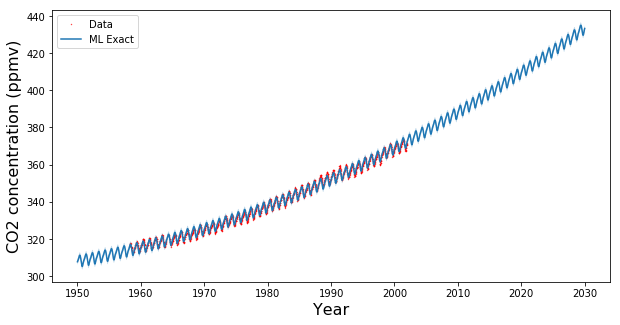

In [12]:
xtest = np.linspace(1950, 2030, 2000)
phitest = feature_transform(xtest)
ytest = phitest.T @ wML

yupper = ytest + 2*sigmaML
ylower = ytest - 2*sigmaML

# Plotting
plt.figure(figsize=(10,5))
plt.plot(Xtrain[0,:],ytrain,'r.',markersize=0.7)
plt.plot(xtest,ytest)
plt.fill_between(xtest, ylower, yupper, alpha=0.3)
plt.legend(['Data', 'ML Exact'])

plt.xlabel('Year', fontsize=16)
plt.ylabel('CO2 concentration (ppmv)', fontsize=16)
plt.show()

## Exercise 3 -  Bayesian linear regression
We now switch problems to make it easier to visualise how Bayesian linear regression works. You are going to write a linear regression model for data from a noisy cubic model
\begin{align}
    y = 3x^3 + x^2 - 10x + 3\epsilon
\end{align}
where $\epsilon$ is standard Gaussian noise. You will work on Bayesian linear regression in the feature space. We will compare two different feature spaces using the model evidence. We use the following forward model
\begin{align}
    p(\textbf{w} | \sigma_\text{prior}^2) &= \mathcal{N}(\textbf{w} | \textbf{0}, \sigma_\text{prior}^2) \\
    p(\textbf{y} | \textbf{w}, \mathbf{\Phi}, \sigma_\text{lik}^2) &= \mathcal{N}(\textbf{y} | \textbf{w}^\top\mathbf{\Phi}, \sigma_\text{lik}^2) 
\end{align}
which leads to a posterior predictive distribution
\begin{align}
    p(y_* | \mathbf{x}_*, \mathcal{D}, \sigma_{\text{lik}}^2) &= \int_{\mathbf{W}} p(\textbf{y} | \textbf{w}, \mathbf{\Phi}, \sigma_\text{lik}^2) p(\mathbf{w} | \mathcal{D}, \sigma_\text{prior}^2, \sigma_\text{lik}^2) \mathrm{d} \mathbf{w} = \mathcal{N}(y_* | \mathbf{\mu}^\top\mathbf{\phi}_*, \sigma_{\text{lik}}^2 + \mathbf{\phi}_*^\top \mathbf{\Lambda}^{-1}\mathbf{\phi}_* )
\end{align}
where
\begin{align}
    \mathbf{\mu} &= \frac{1}{\sigma_{\text{lik}}^2} \mathbf{\Lambda}^{-1}\mathbf{\Phi}\mathbf{y}, \qquad \mathbf{\Lambda} = \frac{1}{\sigma_{\text{prior}}^2}\mathbf{I} + \frac{1}{\sigma_{\text{lik}}^2}\mathbf{\Phi}\mathbf{\Phi}^\top  
\end{align}

The data is drawm from a noisy cubic model

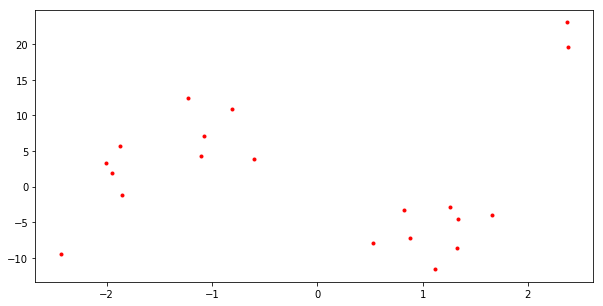

In [13]:
N = 20
Xtrain = np.concatenate([2*np.random.rand(N//2)-2.5, 2*np.random.rand(N//2)+0.5])
ytrain = 3*Xtrain**3 +Xtrain**2 -10*Xtrain + 3*np.random.randn(N)
plt.figure(figsize=(10,5))
plt.plot(Xtrain, ytrain, 'r.')

The feature transform we now consider is a polynomial transform

In [14]:
def polynomial_transform(X):
    X = np.reshape(X, [1,-1])
    Phi = np.concatenate([X, X**2, X**3, X**4, X**5, np.ones(X.shape)], axis=0)
    return Phi

__TODO 5__ Fill in the posterior mean and precision functions. Note that you need to be careful when taking a product of an inverted matrix and a vector e.g. $\mathbf{\Lambda}^{-1} \textbf{x}$. DO NOT invert the matrix, instead use the function `np.linalg.solve(lambda, x)` found here https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linalg.solve.html. This is much more stable.

In [15]:
def prec_post(Phi, sigmaLIK, sigmaPRIOR):
    """Returns a posterior covariance matrix
    Phi: a [D,N] vector of inputs
    sigmaLIK: a positive scalar for the likelihood stddev
    sigmaPRIOR: a positive scalar for the prior stddev
    
    Returns:
        a [D,D] matrix for the posterior precision
    """
    return ((1/np.power(sigmaPRIOR, 2)) * np.identity(Phi.shape[0])) + ((1/np.power(sigmaLIK, 2)) * np.matmul(Phi, Phi.T))


def mean_post(y, Phi, precPOST, sigmaLIK):
    """Returns a posterior mean vector
    y: a [N] vector of training inputs
    Phi: a [D,N] vector of inputs
    precPOST: a [D,D] posterior precision matrix
    sigmaPRIOR: a positive scalar for the prior stddev
    
    Returns:
        a [D] vector for the posterior mean
    """
    return np.ndarray.flatten((1/np.power(sigmaLIK, 2)) * np.matmul((np.linalg.solve(precPOST, Phi)), np.array([y]).T))

Run the chunk of code below. Try to understand what it is doing and even play around with the 2 hyperparameters at the top to get a feel for what everything does.

In [16]:
def plot_PPD(ytrain, Xtrain, sigmaLIK, sigmaPRIOR, transform, plot_limits=5):
    Phitrain = transform(Xtrain)
    
    # Compute the posterior parameters
    precPOST = prec_post(Phitrain, sigmaLIK, sigmaPRIOR)
    muPOST = mean_post(ytrain, Phitrain, precPOST, sigmaLIK)

    # Test data
    xTEST = np.linspace(-plot_limits, plot_limits,2000)
    phiTEST = transform(xTEST)

    # Compute the posterior predictives at the test points
    muPPD = muPOST @ phiTEST
    varPPD = sigmaLIK**2 + np.diag(phiTEST.T @ np.linalg.solve(precPOST, phiTEST))

    # Compute the 2 sigma error bars
    yupper = muPPD + 2*np.sqrt(varPPD)
    ylower = muPPD - 2*np.sqrt(varPPD)

    # Plotting fun
    plt.figure(figsize=(10,5))
    plt.plot(Xtrain,ytrain,'rx',markersize=7)
    plt.plot(xTEST,muPPD)
    plt.fill_between(xTEST, ylower, yupper, alpha=0.3)
    plt.legend(['Data', 'PPD mean'])

    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.xlim(-plot_limits, plot_limits)

    # Set the plotting limits
    yspread = np.amax(ytrain) - np.amin(ytrain)
    plt.ylim(np.amin(ytrain) - yspread/2, np.amax(ytrain) + yspread/2)

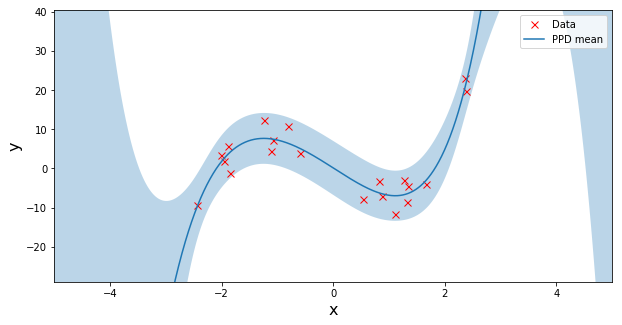

In [17]:
# Hyperparameters
sigmaPRIOR = 5
sigmaLIK = 3
    
# Feature transform for the training data
plot_PPD(ytrain, Xtrain, sigmaLIK, sigmaPRIOR, polynomial_transform, plot_limits=5)

Next we are going to use the following feature transform, called an RBF transform, where RBF stands for _radial basis function_. It has the form
\begin{align}
    \phi(x) = \begin{bmatrix}
    \exp \left \{ -\omega(x - a_1)^2 \right \} \\
    \exp \left \{ -\omega(x - a_2)^2 \right \} \\
    \vdots \\
    \exp \left \{ -\omega(x - a_D)^2 \right \}
    \end{bmatrix}
\end{align}
where the *anchors* $\{a_1, a_2, ... \}$ can be chosen at will. The number $\omega$ controls the width of the RBF transform, essentially controlling the smoothness of the resulting function. Note that this feature transform has no bias, enforcing 0 mean far away from the data.

In [18]:
def rbf_transform(X, anchors, bandwidth):
    X = np.reshape(X, [1,-1])
    anchors = np.reshape(anchors, [-1,1])
    
    Phi = np.exp(-bandwidth*(anchors - X)**2)
    return Phi

In this code we use the training inputs as the anchors (this is a special case of a model called a Gaussian process). Notice how far away from the data, the uncertainty increases.

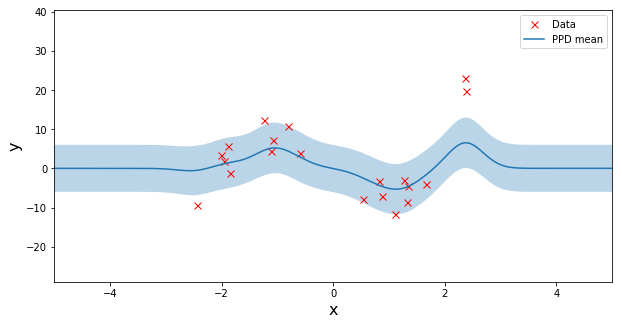

In [19]:
# Hyperparameters
ANCHORS = Xtrain
BANDWIDTH = 5
sigmaPRIOR = 1
sigmaLIK = 3

# Feature transform for the training data
rbf_func = lambda x: rbf_transform(x, ANCHORS, BANDWIDTH)
plot_PPD(ytrain, Xtrain, sigmaLIK, sigmaPRIOR, rbf_func, plot_limits=5)

__TODO 6__ Play around with the bandwidth until you think the plot looks senisible. Be careful though because the numerics are slightly unstable in this particular implementation. Note that this model has no bias, what does that mean? You may find your answer by changing the plot limits to be very wide, and comparing with the polynomial model. Write your answer below

No bias means that the model can always fit the data if we want because the class of models is capable of exactly fitting the data. We can have no difference in expected values vs. true values. 